In [1]:
# Install OS dependencies.  This only needs to be run once for each new notebook instance.
!pip install PyAthena

    100% |████████████████████████████████| 51kB 19.8MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 24.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pyathena import connect
from pyathena.util import as_pandas

# Import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline
pd.set_option('display.max_columns', None)

s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()


# location of the queries to generate materialized views from the MIMIC code repository
queries_dir = './athena_sql/'

In [3]:
# Load in the query from file
query='DROP TABLE IF EXISTS mimiciii.vitalsfirstday;'
cursor.execute(query)
f = os.path.join(queries_dir,'vitals-first-day.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'vitalsfirstday\' using {} ...'.format(f),end=' ')
cursor.execute(query)
print('done.')


Generating table 'vitalsfirstday' using ./athena_sql/vitals-first-day.sql ... done.


In [3]:
query = """
select *
from mimiciii.vitalsfirstday;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
df = as_pandas(cursor)

In [5]:
df.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,2,163353,243653,140.0,140.0,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,211552,75.0,168.0,111.785714,64.0,217.0,102.960000,28.0,74.0,55.720000,40.000000,259.000,75.692812,5.0,24.0,17.361111,36.200001,37.599998,37.002881,74.0,100.0,97.870968,136.0,306.0,232.416667
2,4,185777,294638,74.0,111.0,89.217391,97.0,139.0,118.000000,55.0,81.0,69.000000,69.000000,100.333,85.333321,18.0,32.0,25.352941,36.333334,37.444445,36.844445,91.0,100.0,97.500000,153.0,266.0,199.666667
3,6,107064,228232,76.0,100.0,84.160000,127.0,187.0,153.647059,40.0,72.0,56.558824,72.666702,100.000,84.539218,8.0,20.0,12.320000,36.000002,37.333332,36.515152,84.0,100.0,99.200000,102.0,181.0,148.500000
4,7,118037,236754,115.0,121.0,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(59247, 27)

In [7]:
df.subject_id.value_counts().head()

13033    41
109      38
11861    35
5060     30
20643    25
Name: subject_id, dtype: int64

In [8]:
df.icustay_id.value_counts().head()

264191    1
277138    1
299655    1
295557    1
297604    1
Name: icustay_id, dtype: int64

In [9]:
df.hadm_id.value_counts().head()

163281    7
186706    7
123178    6
175448    6
109520    6
Name: hadm_id, dtype: int64

In [10]:
df.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,2,163353,243653,140.0,140.0,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,211552,75.0,168.0,111.785714,64.0,217.0,102.960000,28.0,74.0,55.720000,40.000000,259.000,75.692812,5.0,24.0,17.361111,36.200001,37.599998,37.002881,74.0,100.0,97.870968,136.0,306.0,232.416667
2,4,185777,294638,74.0,111.0,89.217391,97.0,139.0,118.000000,55.0,81.0,69.000000,69.000000,100.333,85.333321,18.0,32.0,25.352941,36.333334,37.444445,36.844445,91.0,100.0,97.500000,153.0,266.0,199.666667
3,6,107064,228232,76.0,100.0,84.160000,127.0,187.0,153.647059,40.0,72.0,56.558824,72.666702,100.000,84.539218,8.0,20.0,12.320000,36.000002,37.333332,36.515152,84.0,100.0,99.200000,102.0,181.0,148.500000
4,7,118037,236754,115.0,121.0,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.loc[df.subject_id==13033].head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
15726,13033,106376,298550,86.0,130.0,105.160000,107.0,220.0,154.680000,60.0,130.0,95.360000,74.0,158.0,109.520000,7.0,25.0,16.500000,35.833333,37.888887,36.880952,94.0,100.0,98.708333,129.0,252.0,192.833333
15727,13033,106445,225504,69.0,117.0,88.230769,100.0,232.0,150.074074,60.0,142.0,92.148148,69.0,164.0,105.720000,7.0,26.0,14.772727,35.555556,36.833335,36.322223,90.0,100.0,96.720000,72.0,377.0,142.100000
15728,13033,107337,201586,67.0,82.0,74.956522,109.0,178.0,137.391304,65.0,109.0,87.000000,75.0,123.0,97.318182,9.0,22.0,13.954545,36.388889,36.777776,36.622222,96.0,99.0,97.304348,70.0,242.0,146.700000
15729,13033,107751,285451,72.0,100.0,88.363636,82.0,201.0,123.181818,52.0,126.0,78.181818,58.0,144.0,87.000000,3.0,22.0,11.652174,35.555556,36.333334,36.041667,95.0,100.0,99.000000,51.0,177.0,126.666667
15730,13033,108977,210032,92.0,128.0,104.549020,77.0,190.0,107.166667,37.0,111.0,51.518519,51.0,135.0,69.603774,14.0,28.0,18.686275,36.888890,38.833334,38.055556,54.0,100.0,95.051282,98.0,205.0,135.583333


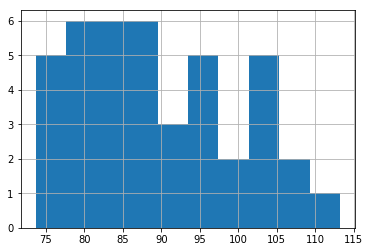

In [12]:
df.loc[df.subject_id==13033].heartrate_mean.hist()

In [13]:
query = """
select *
from mimiciii.admissions;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
adm = as_pandas(cursor)

In [14]:
adm.shape

(58976, 19)

In [15]:
adm.subject_id.value_counts().head()

13033    42
109      34
11861    34
5060     31
20643    24
Name: subject_id, dtype: int64

In [16]:
adm.hadm_id.value_counts().head()

135166    1
156441    1
138006    1
131861    1
133908    1
Name: hadm_id, dtype: int64

In [17]:
adm.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [18]:
adm.admission_location.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: admission_location, dtype: int64

In [19]:
query = """
SELECT 
mimiciii.vitalsfirstday.heartrate_mean,
mimiciii.vitalsfirstday.sysbp_mean,
mimiciii.vitalsfirstday.diasbp_mean,
mimiciii.vitalsfirstday.meanbp_mean,
mimiciii.vitalsfirstday.resprate_mean,
mimiciii.vitalsfirstday.tempc_mean,
mimiciii.vitalsfirstday.spo2_mean,
mimiciii.vitalsfirstday.glucose_mean,
mimiciii.admissions.marital_status,
mimiciii.admissions.diagnosis, 
mimiciii.admissions.hospital_expire_flag
FROM mimiciii.admissions INNER JOIN mimiciii.vitalsfirstday 
ON mimiciii.admissions.hadm_id = mimiciii.vitalsfirstday.hadm_id;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
joined_df = as_pandas(cursor)

In [20]:
joined_df.head()

,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,marital_status,diagnosis,hospital_expire_flag
0,79.086957,102.045455,54.363636,65.500000,20.869565,36.398148,98.950000,167.280000,MARRIED,SEPSIS,0
1,154.612903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NEWBORN,0
2,81.785714,99.465116,59.651163,74.023810,12.186047,36.476190,99.666667,138.333333,MARRIED,UNSTABLE ANGINA\CATH WITH BRACHY S/B,0
3,72.733333,116.066667,39.200000,60.633333,15.033333,37.027778,99.172414,166.333333,MARRIED,CONGESTIVE HEART FAILURE,0
4,76.681818,132.750000,47.550000,69.333333,13.863636,36.644445,99.863636,180.800000,MARRIED,CONGESTIVE HEART FAILURE,0


In [21]:
joined_df.loc[joined_df.diagnosis == 'PNEUMONIA'].hospital_expire_flag.value_counts()

0    1348
1     283
Name: hospital_expire_flag, dtype: int64

In [22]:
joined_df.shape

(59247, 11)

In [68]:
283/(283+1348)

0.17351318209687308

In [66]:
joined_df.diagnosis.value_counts()

NEWBORN                                                                                                6559
PNEUMONIA                                                                                              1631
SEPSIS                                                                                                 1265
CONGESTIVE HEART FAILURE                                                                               1000
CORONARY ARTERY DISEASE                                                                                 887
CHEST PAIN                                                                                              800
ALTERED MENTAL STATUS                                                                                   748
INTRACRANIAL HEMORRHAGE                                                                                 748
GASTROINTESTINAL BLEED                                                                                  729
ABDOMINAL PAIN              

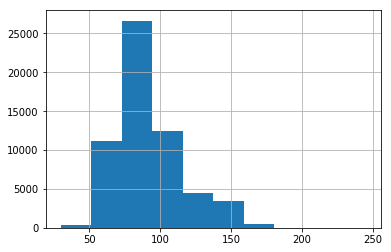

In [56]:
joined_df.heartrate_mean.hist()

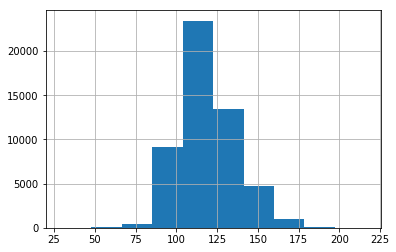

In [57]:
joined_df.sysbp_mean.hist()

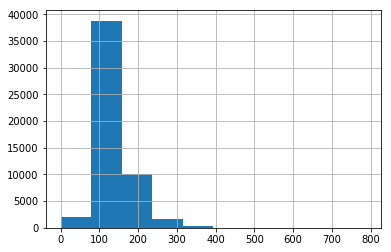

In [65]:
joined_df.drop(joined_df.index[joined_df.glucose_mean > 1000],axis=0).glucose_mean.hist()